#### How to optain vector representations of data
Where do embeddings come from? How are they created? 
In this notebook we will be taking a first principles approach to discover how embeddings are created with deep learning models


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K 
from tensorflow.keras import losses
from scipy.stats import norm

In [7]:
(X_tr, Y_tr), (X_te, Y_te) = mnist.load_data()

In [8]:
X_tr, X_te = X_tr.astype("float32")/255, X_te.astype("float32")/255
X_tr_flat, X_te_flat = X_tr.reshape(X_tr.shape[0], -1), X_te.reshape(X_te.shape[0], -1)

In [9]:
print(X_tr.shape, X_te.shape)
print(X_tr_flat.shape, X_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [10]:
# set neural network parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

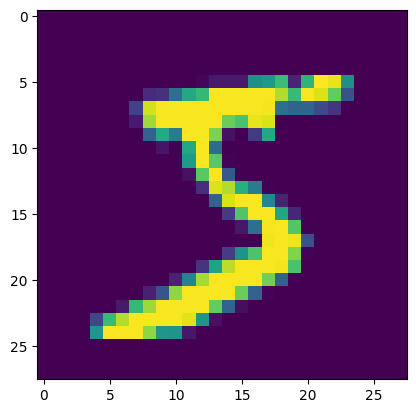

In [12]:
plt.imshow(X_tr[0])

In [13]:
# write sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0, stddev=1.0)
    return mu + K.exp(log_var) * eps

In [14]:
# Encoder - from 784>256>128>2
input_flat = Input(shape=(X_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation="relu")(input_flat)
x_flat = Dense(n_hidden // 2, activation="relu")(x_flat)

# hidden state, which we will pass into a model to get the encoder
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim))

In [16]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(X_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

TypeError: Inputs to a layer should be tensors. Got '<keras.src.layers.core.lambda_layer.Lambda object at 0x2ac622850>' (of type <class 'keras.src.layers.core.lambda_layer.Lambda'>) as input for layer 'decoder_conv'.

In [17]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(input_flat,
                                                 outputs_flat) * X_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(input_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

NameError: name 'outputs_flat' is not defined

In [ ]:
# train
vae_flat.fit(
    X_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(
        X_te_flat, None),
    verbose=1
)

### Visualize Embeddings


In [ ]:
# Build encoders
encoder_f = Model(input_flat, z_flat)  # flat encoder

In [ ]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(X_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=Y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

## Using more advanced models based on the Transformer architechture you can embed sentences aswell.


In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [3]:
embeddings = model.encode(sentence)

# pring the embeddings
print(embeddings)

[[ 0.37061948  0.26414216  0.21265647 ...  0.14994505 -0.2579494
  -0.23970771]
 [ 0.6693336   0.4009495  -0.48208418 ...  0.10645908 -1.5067166
  -0.0154735 ]
 [-0.26555917  0.11172473 -0.14733058 ...  0.42197433  0.8839461
   0.10763902]]


In [4]:
embeddings.shape

(3, 384)

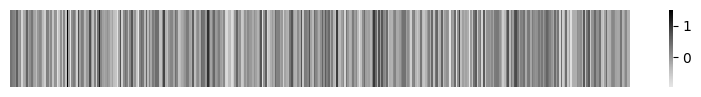

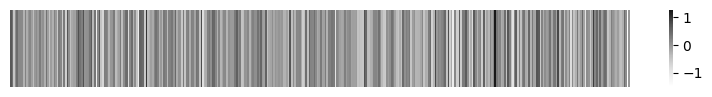

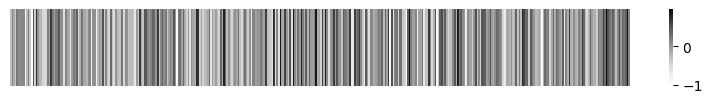

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embeddings[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embeddings[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embeddings[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

##### Calculating Euclidean Distance

In [ ]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

In [ ]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

In [ ]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

In [ ]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

In [ ]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

In [ ]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

### Dot Product
Measures the magnitude of the projection of one vector onto the other.

In [ ]:
# Dot Product
np.dot(zero_A,zero_B)

In [ ]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

### Cosine Distance
Measure the difference in directionality between vectors.

In [ ]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

In [ ]:
zero_A/zero_B

In [6]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [ ]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

### Check the embedding distace calculation using the defined embedding functions

In [8]:
import numpy as np

In [9]:
#Dot Product
print("Distance 0-1:", np.dot(embeddings[0], embeddings[1]))
print("Distance 0-2:", np.dot(embeddings[0], embeddings[2]))
print("Distance 1-2:", np.dot(embeddings[1], embeddings[2]))

Distance 0-1: 26.49789
Distance 0-2: 2.0785737
Distance 1-2: 4.019209


In [10]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embeddings[0], embeddings[1]))
print("Distance 0-2: ", cosine_distance(embeddings[0], embeddings[2]))
print("Distance 1-2: ", cosine_distance(embeddings[1], embeddings[2]))

Distance 0-1:  0.5350335240364075
Distance 0-2:  0.9639393799006939
Distance 1-2:  0.9288791492581367
